# Significant aspects of model construction

* econ status
* ~bubbles~
* spatiality
* mobility

Metrics upon which to assess these:
* cases over time
* deaths over time
* effective R at different points
* constraint-specific measures (e.g. cases over time per district in models with districts)

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import pylab as plt
from os.path import isfile, join
from glob import glob
import subprocess
import re


import seaborn as sns
sns.set(style="darkgrid")

## Section A. Define Functions needed 
### A1. First the model inputs and outputs to include:
- processModelOutput: decides the format of the files that will be output
- processInfections: the format of the infections file
- findROFInstance: total number of individuals infected by the introduction of an infected person (is this returned at the end of a model run?
- WorldBankMASONmodel: defines teh input directory for the parameters to be used, the format of the output files with the aggregate figures and the infections, and how we edit the parameters and includes the amount of memory used in the server to run the model

In [2]:
def processModelOutput(filename):
    r_data = pd.read_csv(filename, sep='\t')
    r_data['districtId'] = [int(str(x).split('_')[1]) for x in r_data["myId"]]
    return {'results': r_data}

def processInfections(filename):
    r_data = pd.read_csv(filename, sep='\t')
    return {'results': r_data}
    

def findROFInstance():
    # total number of individuals infected by the introduction of an infectious person
    return beta * n

def WorldBankMASONmodel(myOutputPrefix, seed, paramfile, beta, numDays=90):
    
    dataDir = "/home/wb488473/Disease-Modelling-SSA/data/verification/"
    #"/Users/swise/workspace/worldbank/Disease-Modelling-SSA/data/verification/"
    exportFilename = myOutputPrefix + "_agg_" + str(seed) + "_" + str(beta) + ".txt"
    exportInfectionsFilename = myOutputPrefix + "_Infections_" + str(seed) + "_" + str(beta) + ".txt"
    
    subprocess.call(['java', '-Xms20G', '-jar', '../java/WorldBankCovid19/libs/WB_covid19ABM.jar', str(numDays), 
                     dataDir, str(beta), str(seed), exportFilename, paramfile, exportInfectionsFilename])
    
    # Sophie upped the -Xms to 20G from 6GB
    #return processModelOutput(exportFilename)
    return processInfections(exportInfectionsFilename)

### A2. Then the function needed for plots

In [56]:
def plotMetric(files, prefix, suffix, metrics = [], symbol = "-", alpha=1, weighting = 1):
    myAvgLine = []
    index = 0
    template = "^" + prefix + ".*" + suffix + "$"

    for f in files:

        if(re.search(template, f) != None): # f.startswith(prefix) and 
            r_data_raw = pd.read_csv(path + f, sep='\t')
            
            r_data = r_data_raw.groupby('time', as_index=False).agg({'metric_died_count': 'sum', 'metric_new_hospitalized': 'sum', 
                                    'metric_new_critical': 'sum', 'metric_new_cases_asympt': 'sum',
                                    'metric_new_cases_sympt': 'sum', 'metric_new_deaths': 'sum', 
                                    'metric_new_recovered': 'sum', 'metric_currently_infected': 'sum'})

            totcases = []
            for metric in metrics:
                if len(totcases) == 0:
                    totcases = r_data[metric]
                else:        
                    totcases = totcases + r_data[metric]
            #totcases = r_data[metric]
            
            if len(myAvgLine) == 0:
                myAvgLine = totcases
            else:
                myAvgLine += totcases
            
            # plot it
            plt.plot(r_data["time"][1:], weighting * totcases[1:], symbol, alpha=alpha)
            index += 1
    return {"myLine": weighting * myAvgLine/index, "myTime": r_data["time"]}

## Section B: Run the model scenarios
In this part we are able to use the functions defined above to run different versions of the model to create different outputs

### B0. Undifferentiated base case (Sarah's example with all explanation)

Individuals are created without distinct statuses and their interaction is perfect mixing with the entire community. There is a single district in which each agent is initialised and movement between districts (being meaningless) is zeroed out. Thus, status, social groups, and space are all excluded from this scenario.

The data directory associated with this case is inunder the directory **data/verification/** and the specific set of parameters is as given in the file **data/verification/params_default1Dist.txt**. In particular:

* the census file has all economic statuses set to the value "Default" and all locations for home and work set to an imaginary "District 1"
* the daily transitions files are both set to 100% chance of moving from District 1 to District 1.
* mobility rates do not decrease after a lockdown...
* the lockdown file is empty of scheduled lockdowns, however, for belt-and-bracers insurance!

The infection parameters are the defaults as seen in the config/covasim_infect_transitions.txt

The data to vary are therefore the following:
* **numWeeklyInteractionsByStatus_default.txt**: a record of how many interactions agents with the "Default" status should have per week
* **lineList_5Perc_singleDist.txt**: the infections to seed in the single district.

An exploration of these is given below.

* initialise with 20 cases
* comparison: .03 and .3 betas
* population sizes: 10% versus this 5%

Running the scenarios.

(WANT MORE SCENARIOS?? Just add more hateful loops! Or change betas to pop size, etc! Add new param files! Go hog wild!!!)

### B1. Beta comparisons on country as one district

I have changed this from the above examples by making it 90 days long rather than 30 in the function of WorldBankMasonModel itself. Then, I have added betasPerScenario below so as to have a range between 0.03 and 0.9, to show the full trajectory across this time period. The i in range just refers to the number of iterations for each run and the number assigned to it. Below the model runs iterations labelled 2,3,4 and 5. The mean value is generated but all are displayed in the plot

In [ ]:
paramsPerScenario = ["../data/verification/params_default1Dist.txt"]   
betasPerScenario = [0.03, 0.3, 0.6, 0.9]
myOutputPrefix= "/home/wb488473/Disease-Modelling-SSA/data/verification/output/sweep/"

outputs = {}
for paramsFile in paramsPerScenario:
    for myBeta in betasPerScenario:
        for i in range(2,5):
            myRunName = paramsFile + "_" + str(myBeta) + "_" + str(i)
            exportFilename ="sweep_default1Dist_betaComparison_"
            myO = WorldBankMASONmodel(myOutputPrefix + exportFilename, i, paramsFile, myBeta)
            outputs[myRunName] = myO

### B2. Beta comparisons on country as multiple districts (but single econ status)
So this scenario is for comparison to check that the mobility between districts is working, when compared to the whole country as one district. It is to enable us to compare the two. Note that people still are only moving between home and community, and this doesn't include the work/school compartment. 

In [ ]:
paramsPerScenario = ["../data/verification/params_defaultMultiDist.txt"]   
betasPerScenario = [0.03, 0.3, 0.6, 0.9]
myOutputPrefix= "/home/wb488473/Disease-Modelling-SSA/data/verification/output/sweep/"

outputs = {}
for paramsFile in paramsPerScenario:
    for myBeta in betasPerScenario:
        for i in range(2,5):
            myRunName = paramsFile + "_" + str(myBeta) + "_" + str(i)
            exportFilename ="sweep_defaultMultiDist_betaComparison_"
            myO = WorldBankMASONmodel(myOutputPrefix + exportFilename, i, paramsFile, myBeta)
            outputs[myRunName] = myO

### B3. Beta comparisons on country as multiple districts (with multiple econ statuses)
Once establishing mobility is working, this then enables us to see what happens when we add the work/school compartment, along with its accompanying changes in probabilities of leaving the house, and mixing differently for 8 hours a day during the week, depending on the interaction matrix. It is to enable us to compare whether people moving between home and community, versus moving between home-work/school-community makes a difference to the dynamics of the infection in the model. 

In [ ]:
paramsPerScenario = ["../data/verification/params_multiStatusMultiDist.txt"]   
betasPerScenario = [0.03, 0.3, 0.6, 0.9]
myOutputPrefix= "/home/wb488473/Disease-Modelling-SSA/data/verification/output/sweep/"

outputs = {}
for paramsFile in paramsPerScenario:
    for myBeta in betasPerScenario:
        for i in range(2,5):
            myRunName = paramsFile + "_" + str(myBeta) + "_" + str(i)
            exportFilename ="sweep_multiStatusMultiDist_betaComparison_"
            myO = WorldBankMASONmodel(myOutputPrefix + exportFilename, i, paramsFile, myBeta)
            outputs[myRunName] = myO

Now before running the next section, I transfer all the outputs to relevant folders within sweep because otherwise if we accidentally run the code again for producing new output, it will write to the same file and append, which can cause issues later on

## Section C: Plot the model results
In this section, we're able to plot different outputs on the same graph to compare (using the plotMetric function created in section A)

### C1. Plot B1 results - Beta comparisons on country as one district

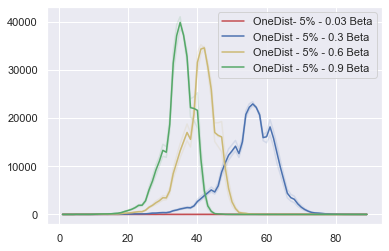

In [57]:
#path = "/home/wb488473/Disease-Modelling-SSA/data/verification/output/sweep/single_district/"
path = "/Users/swise/workspace/worldbank/Disease-Modelling-SSA/data/verification/single_district/"

files = os.listdir(path)

prefix = "sweep_default1Dist_betaComparison__agg_"
prefix2 = "sweep_default1Dist_betaComparison__agg_"
#prefix3 = ""

line1 = plotMetric(files, prefix, "0.03.txt", ["metric_new_cases_sympt"],'r-', 0.15, weighting=4)
line2 = plotMetric(files, prefix, "0.3.txt", ["metric_new_cases_sympt"], 'b-', 0.15)
line3 = plotMetric(files, prefix, "0.6.txt", ["metric_new_cases_sympt"], 'y-', 0.15)
line4 = plotMetric(files, prefix, "0.9.txt", ["metric_new_cases_sympt"], 'g-', 0.15)
#line5 = plotMetric(files, prefix2, "0.1.txt", "metric_new_cases_sympt", 'g', 0.15)
#line6 = plotMetric(files, prefix2, "0.05.txt", "metric_new_cases_sympt", 'y', 0.15)

plt.plot(line1["myTime"][1:], line1['myLine'][1:], 'r', label="OneDist- 5% - 0.03 Beta")
plt.plot(line2["myTime"][1:], line2['myLine'][1:], 'b', label="OneDist - 5% - 0.3 Beta")
plt.plot(line3["myTime"][1:], line3['myLine'][1:], 'y', label="OneDist - 5% - 0.6 Beta")
plt.plot(line4["myTime"][1:], line4['myLine'][1:], 'g', label="OneDist - 5% - 0.9 Beta")
#plt.plot(line3["myTime"][1:], line3['myLine'][1:], 'g', label="Perfect Mixing - .10 Beta")
plt.legend()

plt.savefig(path + "1Dist_beta_comps_90days.png", dpi=300)

In [ ]:
line1['myLine']

### C2. Plot B2 results - Beta comparisons on country as multiple districts

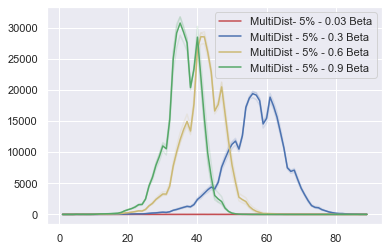

In [58]:
#path = "/home/wb488473/Disease-Modelling-SSA/data/verification/output/sweep/multi_district/"
path = "/Users/swise/workspace/worldbank/Disease-Modelling-SSA/data/verification/multi_district/"


files = os.listdir(path)

prefix = "sweep_defaultMultiDist_betaComparison__agg_"
prefix2 = "sweep_multiStatusMultiDist_betaComparison__agg_"
#prefix3 = ""

line1 = plotMetric(files, prefix, "0.03.txt", ["metric_new_cases_sympt"], 'r-', 0.15, weighting=4)
line2 = plotMetric(files, prefix, "0.3.txt", ["metric_new_cases_sympt"], 'b-', 0.15)
line3 = plotMetric(files, prefix, "0.6.txt", ["metric_new_cases_sympt"], 'y-', 0.15)
line4 = plotMetric(files, prefix, "0.9.txt", ["metric_new_cases_sympt"], 'g-', 0.15)
#line5 = plotMetric(files, prefix2, "0.1.txt", "metric_new_cases_sympt", 'g', 0.15)
#line6 = plotMetric(files, prefix2, "0.05.txt", "metric_new_cases_sympt", 'y', 0.15)

plt.plot(line1["myTime"][1:], line1['myLine'][1:], 'r-', label="MultiDist- 5% - 0.03 Beta")
plt.plot(line2["myTime"][1:], line2['myLine'][1:], 'b-', label="MultiDist - 5% - 0.3 Beta")
plt.plot(line3["myTime"][1:], line3['myLine'][1:], 'y-', label="MultiDist - 5% - 0.6 Beta")
plt.plot(line4["myTime"][1:], line4['myLine'][1:], 'g-', label="MultiDist - 5% - 0.9 Beta")
#plt.plot(line3["myTime"][1:], line3['myLine'][1:], 'g', label="Perfect Mixing - .10 Beta")
plt.legend()

plt.savefig(path + "MultiDist_beta_comps_90days.png", dpi=300)

In [6]:
line1['myLine']


0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
5395    0.0
5396    0.0
5397    0.0
5398    0.0
5399    0.0
Name: metric_new_cases_sympt, Length: 5400, dtype: float64

### C3. Plot B3 results - Beta comparisons on country as multiple districts, with multiple econ statuses

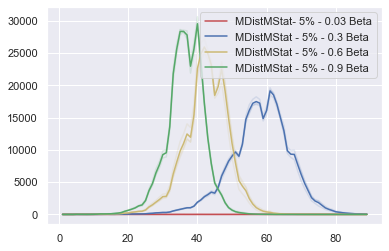

In [59]:
#path = "/home/wb488473/Disease-Modelling-SSA/data/verification/output/sweep/multidist_multistatus/"
path = "/Users/swise/workspace/worldbank/Disease-Modelling-SSA/data/verification/multidist_multistatus/"


files = os.listdir(path)

prefix = "sweep_multiStatusMultiDist_betaComparison__agg_"

line1 = plotMetric(files, prefix, "0.03.txt", ["metric_new_cases_sympt"], 'r-', 0.15, weighting=4)
line2 = plotMetric(files, prefix, "0.3.txt", ["metric_new_cases_sympt"], 'b-', 0.15)
line3 = plotMetric(files, prefix, "0.6.txt", ["metric_new_cases_sympt"], 'y-', 0.15)
line4 = plotMetric(files, prefix, "0.9.txt", ["metric_new_cases_sympt"], 'g-', 0.15)
#line5 = plotMetric(files, prefix2, "0.1.txt", "metric_new_cases_sympt", 'g', 0.15)
#line6 = plotMetric(files, prefix2, "0.05.txt", "metric_new_cases_sympt", 'y', 0.15)

plt.plot(line1["myTime"][1:], line1['myLine'][1:], 'r', label="MDistMStat- 5% - 0.03 Beta")
plt.plot(line2["myTime"][1:], line2['myLine'][1:], 'b', label="MDistMStat - 5% - 0.3 Beta")
plt.plot(line3["myTime"][1:], line3['myLine'][1:], 'y', label="MDistMStat - 5% - 0.6 Beta")
plt.plot(line4["myTime"][1:], line4['myLine'][1:], 'g', label="MDistMStat - 5% - 0.9 Beta")
#plt.plot(line3["myTime"][1:], line3['myLine'][1:], 'g', label="Perfect Mixing - .10 Beta")
plt.legend()

plt.savefig(path + "MultiDistMultiStat_beta_comps_90days.png", dpi=300)

### C4. Now choose one beta and compare across B1, B2, B3 model types

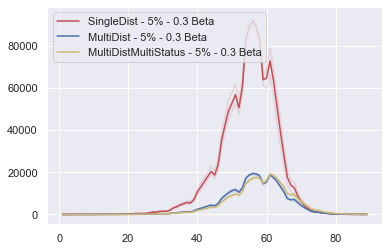

In [67]:
#path = "/home/wb488473/Disease-Modelling-SSA/data/verification/output/sweep/compare/"
path = "/Users/swise/workspace/worldbank/Disease-Modelling-SSA/data/verification/compare/"

files = os.listdir(path)

prefix  = "sweep_default1Dist_betaComparison__agg_"
prefix2 = "sweep_defaultMultiDist_betaComparison__agg_"
prefix3 = "sweep_multiStatusMultiDist_betaComparison__agg_"

line1 = plotMetric(files, prefix, "0.3.txt", ["metric_new_cases_sympt"], 'r-', 0.15, weighting=4)
line2 = plotMetric(files, prefix2, "0.3.txt", ["metric_new_cases_sympt"], 'b-', 0.15)
line3 = plotMetric(files, prefix3, "0.3.txt", ["metric_new_cases_sympt"], 'y-', 0.15)
#line3 = plotMetric(files, prefix, "0.1.txt", "metric_new_cases_sympt", 'g-', 0.15)
#line5 = plotMetric(files, prefix2, "0.1.txt", "metric_new_cases_sympt", 'g', 0.15)
#line6 = plotMetric(files, prefix2, "0.05.txt", "metric_new_cases_sympt", 'y', 0.15)

plt.plot(line1["myTime"][1:], line1['myLine'][1:], 'r', label="SingleDist - 5% - 0.3 Beta")
plt.plot(line2["myTime"][1:], line2['myLine'][1:], 'b', label="MultiDist - 5% - 0.3 Beta")
plt.plot(line3["myTime"][1:], line3['myLine'][1:], 'y', label="MultiDistMultiStatus - 5% - 0.3 Beta")
#plt.plot(line4["myTime"][1:], line4['myLine'][1:], 'y', label="Perfect Mixing - .05 Beta")
#plt.plot(line3["myTime"][1:], line3['myLine'][1:], 'g', label="Perfect Mixing - .10 Beta")
plt.legend()

plt.savefig(path + "comp_dist_statuses_0.3beta.png", dpi=300)



In [ ]:
#line3 = plotMetric(files, "exportPerfect", "0.3.txt", "metric_new_cases_sympt", 'b-', 0.15)
#plt.plot(line3["myTime"][1:], line3['myLine'][1:], 'r', label="Perfect Mixing - .30 Beta")


Direct comparison of spikiness in bubble version

In [ ]:
path = "/Users/swise/workspace/worldbank/Disease-Modelling-SSA/data/verification/output/"
files = os.listdir(path)

prefix = "exportBubblesOf30_0_"
prefix2 = "testing_30bubbles_weekdayWeekendSame_"

line1 = plotMetric(files, prefix, "0.1.txt", ["metric_new_cases_sympt"], 'r-', 0.15)
line2 = plotMetric(files, prefix2, "0.1.txt", ["metric_new_cases_sympt"], 'b-', 0.15)
#line4 = plotMetric(files, prefix, "0.05.txt", "metric_new_cases_sympt", 'y-', 0.15)
#line3 = plotMetric(files, prefix, "0.1.txt", "metric_new_cases_sympt", 'g-', 0.15)
#line5 = plotMetric(files, prefix2, "0.1.txt", "metric_new_cases_sympt", 'g', 0.15)
#line6 = plotMetric(files, prefix2, "0.05.txt", "metric_new_cases_sympt", 'y', 0.15)

plt.plot(line1["myTime"][1:], line1['myLine'][1:], 'r', label="1hr WD, 3hr WE")
plt.plot(line2["myTime"][1:], line2['myLine'][1:], 'b', label="2hr both")
#plt.plot(line2["myTime"][1:], line2['myLine'][1:], 'b', label="Perfect Mixing - .03 Beta")
#plt.plot(line4["myTime"][1:], line4['myLine'][1:], 'y', label="Perfect Mixing - .05 Beta")
#plt.plot(line3["myTime"][1:], line3['myLine'][1:], 'g', label="Perfect Mixing - .10 Beta")
plt.title("Bubbles - 5% - .1 Beta")
plt.legend()

plt.savefig(path + "leisureTimeComparison.png", dpi=300)

Calculating the r_eff

In [ ]:
path = "/Users/swise/workspace/worldbank/Disease-Modelling-SSA/notebooks/"
filename = "infections_0.016_4_180_4.txt"
r_data = pd.read_csv(path + filename, sep='\t')


In [ ]:
infections = r_data[r_data["ContagiousAt"] != '1.7976931348623157E308']
infections["HostNew"] = infections["Host"].astype(float).astype(str)
infections["SourceNew"] = infections["Source"].astype(str)
infections


In [ ]:
allSources = infections["SourceNew"]

In [ ]:
infections["finishedAt"] = min(infections["DiedAt"], infections["RecoveredAt"])

In [ ]:
allSources.value_counts()

In [ ]:
x = "../data/verification/params_5perc_bubbles_30.txt"

x.split(".")[-2].split("/")[-1]

## Comparison of population sizes

#### Deaths over time

#### Measuring R

## Introducing one constraint at a time

### Social Bubbles

### Status

### Spatial Partitioning

(districts exist)

## Combining these constraints

* Social bubbles + status
* Social bubbles + space
* Status + space
* All three

## Mobility

### Weekday/weekend

### Interdisctrict

## Future work: interventions

* lockdowns
* someday, hygiene
* someday, school closures

## Template

such description wow

#### Cases over time


#### Deaths over time

#### Measuring R

#### Constraint-specific?